In [4]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

ModuleNotFoundError: No module named 'bs4'

In [5]:
import sys
sys.executable

'/Users/gregorykell/anaconda3/envs/EvidenceQA/bin/python3'

In [ ]:
!python -m ipykernel install --user --name=fin_

In [2]:
with open('data/manually_collected/text/0_original.txt', 'r') as handle:
    caption = handle.readlines()[0]
    
with open('data/manually_collected/text/10450.txt', 'r') as handle:
    caption2 = handle.readlines()[0]

In [15]:
doc1 = nlp(caption)
doc2 = nlp(caption2)
caption2

'Everything on the table, from the fluted glass and goblet to the lobster and crab, is indeed life-like. You can almost smell the lemons. The Dutch proudly displayed such expensive status symbols in their homes, the exotic food and material possessions reminding them of the good things in life, even as the watch reminds them of their transience. The bread and wine, in a touch of Christian symbolism, echo the moralizing message of vanitas, or vanity: all earthly things must pass.'

In [13]:
doc1

The symbolism of the skulls in this painting is obvious, but the rose (quick to wilt) and oil lamp (easily snuffed out) also refer to life’s brevity and fragility. The vanitas symbolism is underscored by the Latin inscription underneath: “All that is human is smoke, show, vanity and the picture of a stage.”

In [10]:
skull_ent = Span(doc1, 4, 5, label="ITEM") # create a Span for the new entity
rose_ent = Span(doc1, 13, 14, label="ITEM")
rose_desc_ent = Span(doc1, 15,18, label="EXPLANATION")
oil_lamp_ent = Span(doc1, 20, 22, label="ITEM")
oil_lamp_desc = Span(doc1, 22, 26, label="EXPLANATION")
life_brief_fragile = Span(doc1, 30, 35, label="CONCEPT")

doc1.ents = list(doc1.ents) + [skull_ent, rose_ent, rose_desc_ent, oil_lamp_ent, oil_lamp_desc, life_brief_fragile]

In [14]:
for ent in doc1.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Latin 208 213 NORP


In [ ]:
# Look into constituency parsing - noun phrase and verb phrase linked to in a particular node
# Query conceptNet - see whether skull is linked to death, check out other open knowledge graphs
# Copy and paste several descriptions into Overleaf doc.
# Any way to farm more than that
# Just use text: symbolism in Vanitas paintings

The symbolism of the skulls in this painting is obvious, but the rose (quick to wilt) and oil lamp (easily snuffed out) also refer to life’s brevity and fragility. The vanitas symbolism is underscored by the Latin inscription underneath: “All that is human is smoke, show, vanity and the picture of a stage.”

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [42]:
entity_pairs = []

for sent in doc.sents:
    entity_pairs.append(get_entities(sent.text))
    


In [43]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [35]:
get_relation("John completed the task")

'completed'

In [36]:
relations = [get_relation(i.text) for i in tqdm(doc.sents)]

2it [00:00, 116.92it/s]


In [39]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [40]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

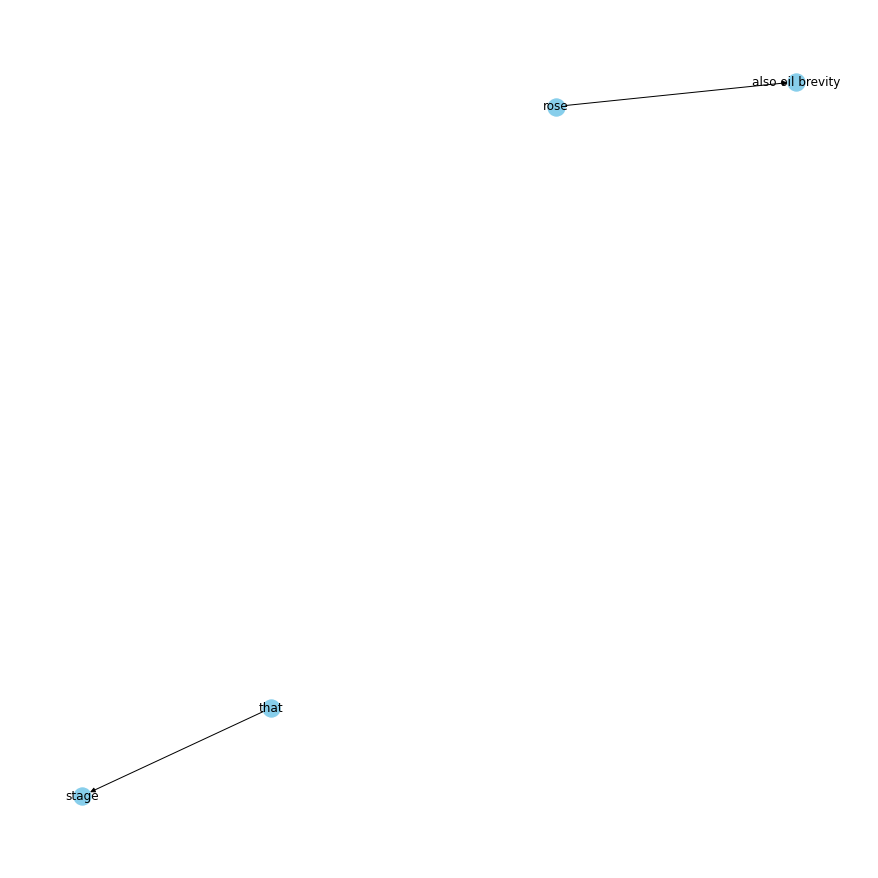

In [41]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Everything on the table, from the fluted glass and goblet to the lobster and crab, is indeed life-like. You can almost smell the lemons. The Dutch proudly displayed such expensive status symbols in their homes, the exotic food and material possessions reminding them of the good things in life, even as the watch reminds them of their transience. The bread and wine, in a touch of Christian symbolism, echo the moralizing message of vanitas, or vanity: all earthly things must pass.
Everything -> nsubj
on -> prep
the -> det
table -> pobj
, -> punct
from -> prep
the -> det
fluted -> amod
glass -> pobj
and -> cc
goblet -> conj
to -> prep
the -> det
lobster -> pobj
and -> cc
crab -> conj
, -> punct
is -> ROOT
indeed -> advmod
life -> npadvmod
- -> punct
like -> acomp
. -> punct
Everything , fluted be , table glass lobster
You -> nsubj
can -> aux
almost -> advmod
smell -> ROOT
the -> det
lemons -> dobj
. -> punct
You , smell , lemons
The -> det
Dutch -> nsubj
proudly -> advmod
displayed -> ROOT

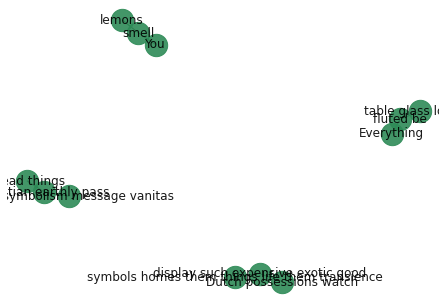

In [82]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sent.text.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)
#     return True

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod", "npadvmod"]
    return any(subs in token.dep_ for subs in deps)
#     return True

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

if __name__ == "__main__":

    text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."

    sentences = getSentences(caption2)
#     sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (caption2)
#     print(text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)